# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 pre-selected sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")
        
        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11712
EM converged at iteration 32, llf=-11471, convergence criterion=9.492e-07 < tolerance=1e-06
EM start iterations, llf=-11725
EM converged at iteration 32, llf=-11483, convergence criterion=9.4917e-07 < tolerance=1e-06
EM start iterations, llf=-11778
EM converged at iteration 32, llf=-11533, convergence criterion=9.5305e-07 < tolerance=1e-06
EM start iterations, llf=-11784
EM converged at iteration 32, llf=-11540, convergence criterion=9.5498e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM converged at iteration 32, llf=-11600, convergence criterion=9.2185e-07 < tolerance=1e-06
EM start iterations, llf=-11858
EM converged at iteration 31, llf=-11607, convergence criterion=9.8993e-07 < tolerance=1e-06
EM start iterations, llf=-11913
EM converged at iteration 32, llf=-11664, convergence criterion=9.4705e-07 < tolerance=1e-06
EM start iterations, llf=-11913
EM converged at iteration 32, llf=-11664, convergence criterion=9.4705e-07 < tolerance=1e-06
E

EM start iterations, llf=-13257
EM converged at iteration 26, llf=-13066, convergence criterion=8.9011e-07 < tolerance=1e-06
EM start iterations, llf=-13318
EM converged at iteration 24, llf=-13137, convergence criterion=9.8707e-07 < tolerance=1e-06
EM start iterations, llf=-13325
EM converged at iteration 27, llf=-13140, convergence criterion=9.1196e-07 < tolerance=1e-06
EM start iterations, llf=-13377
EM converged at iteration 28, llf=-13187, convergence criterion=9.0392e-07 < tolerance=1e-06
EM start iterations, llf=-13377
EM converged at iteration 28, llf=-13187, convergence criterion=9.0392e-07 < tolerance=1e-06
EM start iterations, llf=-13388
EM converged at iteration 29, llf=-13200, convergence criterion=9.3836e-07 < tolerance=1e-06
EM start iterations, llf=-13439
EM converged at iteration 29, llf=-13253, convergence criterion=8.9969e-07 < tolerance=1e-06
EM start iterations, llf=-13444
EM converged at iteration 29, llf=-13257, convergence criterion=9.8877e-07 < tolerance=1e-06


EM start iterations, llf=-14943
EM converged at iteration 30, llf=-14740, convergence criterion=9.3208e-07 < tolerance=1e-06
EM start iterations, llf=-14943
EM converged at iteration 30, llf=-14740, convergence criterion=9.3208e-07 < tolerance=1e-06
EM start iterations, llf=-14952
EM converged at iteration 30, llf=-14749, convergence criterion=9.3123e-07 < tolerance=1e-06
EM start iterations, llf=-15007
EM converged at iteration 30, llf=-14804, convergence criterion=9.0827e-07 < tolerance=1e-06
EM start iterations, llf=-15018
EM converged at iteration 30, llf=-14815, convergence criterion=8.9379e-07 < tolerance=1e-06
EM start iterations, llf=-15067
EM converged at iteration 30, llf=-14863, convergence criterion=8.77e-07 < tolerance=1e-06
EM start iterations, llf=-15074
EM converged at iteration 29, llf=-14870, convergence criterion=9.9154e-07 < tolerance=1e-06
EM start iterations, llf=-15121
EM converged at iteration 29, llf=-14915, convergence criterion=9.6438e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16665
EM converged at iteration 28, llf=-16429, convergence criterion=9.1787e-07 < tolerance=1e-06
EM start iterations, llf=-16670
EM converged at iteration 28, llf=-16434, convergence criterion=9.2033e-07 < tolerance=1e-06
EM start iterations, llf=-16723
EM converged at iteration 28, llf=-16487, convergence criterion=8.912e-07 < tolerance=1e-06
EM start iterations, llf=-16730
EM converged at iteration 28, llf=-16493, convergence criterion=9.0168e-07 < tolerance=1e-06
EM start iterations, llf=-16786
EM converged at iteration 28, llf=-16550, convergence criterion=8.9485e-07 < tolerance=1e-06
EM start iterations, llf=-16786
EM converged at iteration 28, llf=-16550, convergence criterion=8.9485e-07 < tolerance=1e-06
EM start iterations, llf=-16795
EM converged at iteration 28, llf=-16560, convergence criterion=8.7551e-07 < tolerance=1e-06
EM start iterations, llf=-16847
EM converged at iteration 27, llf=-16611, convergence criterion=9.746e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18187
EM converged at iteration 24, llf=-17935, convergence criterion=9.3164e-07 < tolerance=1e-06
EM start iterations, llf=-18250
EM converged at iteration 24, llf=-17996, convergence criterion=9.3213e-07 < tolerance=1e-06
EM start iterations, llf=-18250
EM converged at iteration 24, llf=-17996, convergence criterion=9.3213e-07 < tolerance=1e-06
EM start iterations, llf=-18255
EM converged at iteration 24, llf=-18002, convergence criterion=9.3284e-07 < tolerance=1e-06
EM start iterations, llf=-18306
EM converged at iteration 24, llf=-18051, convergence criterion=9.7619e-07 < tolerance=1e-06
EM start iterations, llf=-18313
EM converged at iteration 24, llf=-18058, convergence criterion=9.7773e-07 < tolerance=1e-06
EM start iterations, llf=-18370
EM converged at iteration 24, llf=-18113, convergence criterion=9.6791e-07 < tolerance=1e-06
EM start iterations, llf=-18377
EM converged at iteration 24, llf=-18121, convergence criterion=9.7545e-07 < tolerance=1e-06


EM start iterations, llf=-12271
EM converged at iteration 41, llf=-12004, convergence criterion=9.9964e-07 < tolerance=1e-06
EM start iterations, llf=-12254
EM converged at iteration 41, llf=-11984, convergence criterion=9.6271e-07 < tolerance=1e-06
EM start iterations, llf=-12297
EM converged at iteration 41, llf=-12032, convergence criterion=9.9423e-07 < tolerance=1e-06
EM start iterations, llf=-12315
EM converged at iteration 42, llf=-12057, convergence criterion=9.5007e-07 < tolerance=1e-06
EM start iterations, llf=-12341
EM converged at iteration 44, llf=-12106, convergence criterion=9.7437e-07 < tolerance=1e-06
EM start iterations, llf=-12340
EM converged at iteration 44, llf=-12103, convergence criterion=9.5311e-07 < tolerance=1e-06
EM start iterations, llf=-12355
EM converged at iteration 41, llf=-12127, convergence criterion=9.8188e-07 < tolerance=1e-06
EM start iterations, llf=-12355
EM converged at iteration 41, llf=-12127, convergence criterion=9.8188e-07 < tolerance=1e-06


EM start iterations, llf=-13766
EM converged at iteration 42, llf=-13570, convergence criterion=9.4798e-07 < tolerance=1e-06
EM start iterations, llf=-13794
EM converged at iteration 40, llf=-13590, convergence criterion=9.864e-07 < tolerance=1e-06
EM start iterations, llf=-13800
EM converged at iteration 42, llf=-13602, convergence criterion=9.5922e-07 < tolerance=1e-06
EM start iterations, llf=-13846
EM converged at iteration 45, llf=-13657, convergence criterion=9.6644e-07 < tolerance=1e-06
EM start iterations, llf=-13846
EM converged at iteration 45, llf=-13657, convergence criterion=9.6644e-07 < tolerance=1e-06
EM start iterations, llf=-13857
EM converged at iteration 45, llf=-13668, convergence criterion=9.6783e-07 < tolerance=1e-06
EM start iterations, llf=-13914
EM converged at iteration 44, llf=-13723, convergence criterion=9.9131e-07 < tolerance=1e-06
EM start iterations, llf=-13921
EM converged at iteration 44, llf=-13729, convergence criterion=9.5532e-07 < tolerance=1e-06
E

EM start iterations, llf=-15500
EM converged at iteration 38, llf=-15284, convergence criterion=9.5781e-07 < tolerance=1e-06
EM start iterations, llf=-15500
EM converged at iteration 38, llf=-15284, convergence criterion=9.5781e-07 < tolerance=1e-06
EM start iterations, llf=-15508
EM converged at iteration 37, llf=-15292, convergence criterion=9.9239e-07 < tolerance=1e-06
EM start iterations, llf=-15564
EM converged at iteration 37, llf=-15346, convergence criterion=9.8995e-07 < tolerance=1e-06
EM start iterations, llf=-15567
EM converged at iteration 38, llf=-15348, convergence criterion=9.4281e-07 < tolerance=1e-06
EM start iterations, llf=-15621
EM converged at iteration 38, llf=-15401, convergence criterion=9.77e-07 < tolerance=1e-06
EM start iterations, llf=-15626
EM converged at iteration 38, llf=-15406, convergence criterion=9.7173e-07 < tolerance=1e-06
EM start iterations, llf=-15668
EM converged at iteration 38, llf=-15448, convergence criterion=9.8043e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17223
EM converged at iteration 33, llf=-16991, convergence criterion=9.7784e-07 < tolerance=1e-06
EM start iterations, llf=-17228
EM converged at iteration 33, llf=-16997, convergence criterion=9.7663e-07 < tolerance=1e-06
EM start iterations, llf=-17281
EM converged at iteration 33, llf=-17048, convergence criterion=9.6687e-07 < tolerance=1e-06
EM start iterations, llf=-17289
EM converged at iteration 33, llf=-17055, convergence criterion=9.6336e-07 < tolerance=1e-06
EM start iterations, llf=-17336
EM converged at iteration 33, llf=-17102, convergence criterion=9.5642e-07 < tolerance=1e-06
EM start iterations, llf=-17336
EM converged at iteration 33, llf=-17102, convergence criterion=9.5642e-07 < tolerance=1e-06
EM start iterations, llf=-17355
EM converged at iteration 33, llf=-17121, convergence criterion=9.6553e-07 < tolerance=1e-06
EM start iterations, llf=-17408
EM converged at iteration 32, llf=-17173, convergence criterion=9.6707e-07 < tolerance=1e-06


EM start iterations, llf=-18730
EM converged at iteration 32, llf=-18465, convergence criterion=9.9392e-07 < tolerance=1e-06
EM start iterations, llf=-18781
EM converged at iteration 32, llf=-18516, convergence criterion=9.6316e-07 < tolerance=1e-06
EM start iterations, llf=-18781
EM converged at iteration 32, llf=-18516, convergence criterion=9.6316e-07 < tolerance=1e-06
EM start iterations, llf=-18789
EM converged at iteration 32, llf=-18526, convergence criterion=9.6042e-07 < tolerance=1e-06
EM start iterations, llf=-18845
EM converged at iteration 32, llf=-18582, convergence criterion=9.5957e-07 < tolerance=1e-06
EM start iterations, llf=-18853
EM converged at iteration 32, llf=-18589, convergence criterion=9.5801e-07 < tolerance=1e-06
EM start iterations, llf=-18904
EM converged at iteration 32, llf=-18639, convergence criterion=9.5899e-07 < tolerance=1e-06
EM start iterations, llf=-18912
EM converged at iteration 32, llf=-18647, convergence criterion=9.5831e-07 < tolerance=1e-06


EM start iterations, llf=-12574
EM converged at iteration 42, llf=-12361, convergence criterion=9.539e-07 < tolerance=1e-06
EM start iterations, llf=-12580
EM converged at iteration 42, llf=-12367, convergence criterion=9.5343e-07 < tolerance=1e-06
EM start iterations, llf=-12631
EM converged at iteration 41, llf=-12418, convergence criterion=9.8091e-07 < tolerance=1e-06
EM start iterations, llf=-12638
EM converged at iteration 41, llf=-12425, convergence criterion=9.8319e-07 < tolerance=1e-06
EM start iterations, llf=-12677
EM converged at iteration 41, llf=-12459, convergence criterion=9.5571e-07 < tolerance=1e-06
EM start iterations, llf=-12688
EM converged at iteration 41, llf=-12469, convergence criterion=9.4202e-07 < tolerance=1e-06
EM start iterations, llf=-12742
EM converged at iteration 43, llf=-12532, convergence criterion=9.4693e-07 < tolerance=1e-06
EM start iterations, llf=-12742
EM converged at iteration 43, llf=-12532, convergence criterion=9.4693e-07 < tolerance=1e-06
E

EM start iterations, llf=-14271
EM converged at iteration 44, llf=-14076, convergence criterion=9.9941e-07 < tolerance=1e-06
EM start iterations, llf=-14324
EM converged at iteration 46, llf=-14133, convergence criterion=9.5609e-07 < tolerance=1e-06
EM start iterations, llf=-14333
EM converged at iteration 45, llf=-14138, convergence criterion=9.7779e-07 < tolerance=1e-06
EM start iterations, llf=-14385
EM converged at iteration 46, llf=-14192, convergence criterion=9.7797e-07 < tolerance=1e-06
EM start iterations, llf=-14385
EM converged at iteration 46, llf=-14192, convergence criterion=9.7797e-07 < tolerance=1e-06
EM start iterations, llf=-14393
EM converged at iteration 46, llf=-14199, convergence criterion=9.4374e-07 < tolerance=1e-06
EM start iterations, llf=-14445
EM converged at iteration 45, llf=-14251, convergence criterion=9.8621e-07 < tolerance=1e-06
EM start iterations, llf=-14454
EM converged at iteration 44, llf=-14258, convergence criterion=9.893e-07 < tolerance=1e-06
E

EM start iterations, llf=-16041
EM converged at iteration 42, llf=-15823, convergence criterion=9.7783e-07 < tolerance=1e-06
EM start iterations, llf=-16041
EM converged at iteration 42, llf=-15823, convergence criterion=9.7783e-07 < tolerance=1e-06
EM start iterations, llf=-16050
EM converged at iteration 42, llf=-15831, convergence criterion=9.7935e-07 < tolerance=1e-06
EM start iterations, llf=-16104
EM converged at iteration 42, llf=-15883, convergence criterion=9.6584e-07 < tolerance=1e-06
EM start iterations, llf=-16113
EM converged at iteration 42, llf=-15893, convergence criterion=9.6219e-07 < tolerance=1e-06
EM start iterations, llf=-16164
EM converged at iteration 42, llf=-15944, convergence criterion=9.5094e-07 < tolerance=1e-06
EM start iterations, llf=-16172
EM converged at iteration 42, llf=-15951, convergence criterion=9.4734e-07 < tolerance=1e-06
EM start iterations, llf=-16227
EM converged at iteration 42, llf=-16005, convergence criterion=9.4074e-07 < tolerance=1e-06


EM start iterations, llf=-17757
EM converged at iteration 37, llf=-17517, convergence criterion=9.6425e-07 < tolerance=1e-06
EM start iterations, llf=-17764
EM converged at iteration 37, llf=-17525, convergence criterion=9.5961e-07 < tolerance=1e-06
EM start iterations, llf=-17813
EM converged at iteration 37, llf=-17573, convergence criterion=9.5991e-07 < tolerance=1e-06
EM start iterations, llf=-17820
EM converged at iteration 37, llf=-17580, convergence criterion=9.6112e-07 < tolerance=1e-06
EM start iterations, llf=-17877
EM converged at iteration 37, llf=-17636, convergence criterion=9.7574e-07 < tolerance=1e-06
EM start iterations, llf=-17877
EM converged at iteration 37, llf=-17636, convergence criterion=9.7574e-07 < tolerance=1e-06
EM start iterations, llf=-17881
EM converged at iteration 37, llf=-17638, convergence criterion=9.7737e-07 < tolerance=1e-06
EM start iterations, llf=-17935
EM converged at iteration 37, llf=-17691, convergence criterion=9.692e-07 < tolerance=1e-06
E

EM start iterations, llf=-18988
EM converged at iteration 37, llf=-18718, convergence criterion=9.8849e-07 < tolerance=1e-06
EM start iterations, llf=-19043
EM converged at iteration 37, llf=-18772, convergence criterion=9.8501e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:29:52.760829.
EM start iterations, llf=-11233
EM converged at iteration 24, llf=-11089, convergence criterion=9.8229e-07 < tolerance=1e-06
EM start iterations, llf=-11246
EM converged at iteration 24, llf=-11101, convergence criterion=9.8602e-07 < tolerance=1e-06
EM start iterations, llf=-11297
EM converged at iteration 24, llf=-11153, convergence criterion=9.4784e-07 < tolerance=1e-06
EM start iterations, llf=-11305
EM converged at iteration 24, llf=-11161, convergence criterion=9.5413e-07 < tolerance=1e-06
EM start iterations, llf=-11364
EM converged at iteration 21, llf=-11220, convergence criterion=9.5203e-07 < tolerance=1e-06
EM start iterations, llf=-11374
EM converged at

EM converged at iteration 22, llf=-12393, convergence criterion=9.6208e-07 < tolerance=1e-06
EM start iterations, llf=-12554
EM converged at iteration 22, llf=-12405, convergence criterion=9.7318e-07 < tolerance=1e-06
EM start iterations, llf=-12587
EM converged at iteration 22, llf=-12437, convergence criterion=9.8675e-07 < tolerance=1e-06
EM start iterations, llf=-12593
EM converged at iteration 23, llf=-12441, convergence criterion=9.3772e-07 < tolerance=1e-06
EM start iterations, llf=-12652
EM converged at iteration 22, llf=-12493, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-12657
EM converged at iteration 22, llf=-12501, convergence criterion=9.6801e-07 < tolerance=1e-06
EM start iterations, llf=-12698
EM converged at iteration 21, llf=-12542, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-12698
EM converged at iteration 21, llf=-12542, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-12704


EM start iterations, llf=-14103
EM converged at iteration 18, llf=-13941, convergence criterion=9.5106e-07 < tolerance=1e-06
EM start iterations, llf=-14151
EM converged at iteration 18, llf=-13989, convergence criterion=9.4807e-07 < tolerance=1e-06
EM start iterations, llf=-14159
EM converged at iteration 18, llf=-13996, convergence criterion=9.4471e-07 < tolerance=1e-06
EM start iterations, llf=-14211
EM converged at iteration 18, llf=-14048, convergence criterion=9.2933e-07 < tolerance=1e-06
EM start iterations, llf=-14211
EM converged at iteration 18, llf=-14048, convergence criterion=9.2933e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 18, llf=-14057, convergence criterion=9.3554e-07 < tolerance=1e-06
EM start iterations, llf=-14270
EM converged at iteration 18, llf=-14108, convergence criterion=9.1161e-07 < tolerance=1e-06
EM start iterations, llf=-14277
EM converged at iteration 17, llf=-14115, convergence criterion=9.9301e-07 < tolerance=1e-06


EM start iterations, llf=-15806
EM converged at iteration 18, llf=-15635, convergence criterion=9.5476e-07 < tolerance=1e-06
EM start iterations, llf=-15806
EM converged at iteration 18, llf=-15635, convergence criterion=9.5476e-07 < tolerance=1e-06
EM start iterations, llf=-15819
EM converged at iteration 18, llf=-15648, convergence criterion=9.4463e-07 < tolerance=1e-06
EM start iterations, llf=-15877
EM converged at iteration 18, llf=-15706, convergence criterion=9.8784e-07 < tolerance=1e-06
EM start iterations, llf=-15879
EM converged at iteration 19, llf=-15709, convergence criterion=9.1691e-07 < tolerance=1e-06
EM start iterations, llf=-15931
EM converged at iteration 18, llf=-15761, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-15938
EM converged at iteration 19, llf=-15768, convergence criterion=9.1061e-07 < tolerance=1e-06
EM start iterations, llf=-15990
EM converged at iteration 19, llf=-15821, convergence criterion=9.3653e-07 < tolerance=1e-06


EM start iterations, llf=-17254
EM converged at iteration 19, llf=-17075, convergence criterion=9.1023e-07 < tolerance=1e-06
EM start iterations, llf=-17268
EM converged at iteration 18, llf=-17088, convergence criterion=9.9765e-07 < tolerance=1e-06
EM start iterations, llf=-17326
EM converged at iteration 18, llf=-17146, convergence criterion=9.8425e-07 < tolerance=1e-06
EM start iterations, llf=-17332
EM converged at iteration 18, llf=-17152, convergence criterion=9.845e-07 < tolerance=1e-06
EM start iterations, llf=-17392
EM converged at iteration 18, llf=-17212, convergence criterion=9.4912e-07 < tolerance=1e-06
EM start iterations, llf=-17392
EM converged at iteration 18, llf=-17212, convergence criterion=9.4912e-07 < tolerance=1e-06
EM start iterations, llf=-17397
EM converged at iteration 18, llf=-17217, convergence criterion=9.6129e-07 < tolerance=1e-06
EM start iterations, llf=-17444
EM converged at iteration 18, llf=-17264, convergence criterion=9.4358e-07 < tolerance=1e-06
E

EM start iterations, llf=-11684
EM converged at iteration 48, llf=-11536, convergence criterion=9.9727e-07 < tolerance=1e-06
EM start iterations, llf=-11687
EM converged at iteration 49, llf=-11538, convergence criterion=9.7439e-07 < tolerance=1e-06
EM start iterations, llf=-11755
EM converged at iteration 43, llf=-11606, convergence criterion=9.7695e-07 < tolerance=1e-06
EM start iterations, llf=-11755
EM converged at iteration 43, llf=-11606, convergence criterion=9.7695e-07 < tolerance=1e-06
EM start iterations, llf=-11768
EM converged at iteration 43, llf=-11620, convergence criterion=9.7256e-07 < tolerance=1e-06
EM start iterations, llf=-11823
EM converged at iteration 39, llf=-11673, convergence criterion=9.9235e-07 < tolerance=1e-06
EM start iterations, llf=-11810
EM converged at iteration 42, llf=-11659, convergence criterion=9.8731e-07 < tolerance=1e-06
EM start iterations, llf=-11791
EM converged at iteration 37, llf=-11634, convergence criterion=9.896e-07 < tolerance=1e-06
E

EM start iterations, llf=-13017
EM converged at iteration 33, llf=-12858, convergence criterion=9.7703e-07 < tolerance=1e-06
EM start iterations, llf=-13026
EM converged at iteration 33, llf=-12870, convergence criterion=9.6707e-07 < tolerance=1e-06
EM start iterations, llf=-13060
EM converged at iteration 33, llf=-12903, convergence criterion=9.8557e-07 < tolerance=1e-06
EM start iterations, llf=-13068
EM converged at iteration 34, llf=-12912, convergence criterion=9.7866e-07 < tolerance=1e-06
EM start iterations, llf=-13103
EM converged at iteration 34, llf=-12946, convergence criterion=9.7656e-07 < tolerance=1e-06
EM start iterations, llf=-13095
EM converged at iteration 33, llf=-12942, convergence criterion=9.6998e-07 < tolerance=1e-06
EM start iterations, llf=-13138
EM converged at iteration 32, llf=-12983, convergence criterion=9.8993e-07 < tolerance=1e-06
EM start iterations, llf=-13138
EM converged at iteration 32, llf=-12983, convergence criterion=9.8993e-07 < tolerance=1e-06


EM start iterations, llf=-14633
EM converged at iteration 24, llf=-14472, convergence criterion=9.8305e-07 < tolerance=1e-06
EM start iterations, llf=-14685
EM converged at iteration 24, llf=-14523, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-14691
EM converged at iteration 24, llf=-14530, convergence criterion=9.927e-07 < tolerance=1e-06
EM start iterations, llf=-14738
EM converged at iteration 24, llf=-14578, convergence criterion=9.4796e-07 < tolerance=1e-06
EM start iterations, llf=-14738
EM converged at iteration 24, llf=-14578, convergence criterion=9.4796e-07 < tolerance=1e-06
EM start iterations, llf=-14751
EM converged at iteration 23, llf=-14590, convergence criterion=9.903e-07 < tolerance=1e-06
EM start iterations, llf=-14809
EM converged at iteration 24, llf=-14646, convergence criterion=9.4544e-07 < tolerance=1e-06
EM start iterations, llf=-14808
EM converged at iteration 24, llf=-14646, convergence criterion=9.5955e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16334
EM converged at iteration 22, llf=-16162, convergence criterion=9.8742e-07 < tolerance=1e-06
EM start iterations, llf=-16334
EM converged at iteration 22, llf=-16162, convergence criterion=9.8742e-07 < tolerance=1e-06
EM start iterations, llf=-16343
EM converged at iteration 22, llf=-16169, convergence criterion=9.8499e-07 < tolerance=1e-06
EM start iterations, llf=-16392
EM converged at iteration 22, llf=-16218, convergence criterion=9.7624e-07 < tolerance=1e-06
EM start iterations, llf=-16397
EM converged at iteration 22, llf=-16222, convergence criterion=9.7284e-07 < tolerance=1e-06
EM start iterations, llf=-16448
EM converged at iteration 22, llf=-16275, convergence criterion=9.6554e-07 < tolerance=1e-06
EM start iterations, llf=-16458
EM converged at iteration 22, llf=-16284, convergence criterion=9.7791e-07 < tolerance=1e-06
EM start iterations, llf=-16501
EM converged at iteration 22, llf=-16328, convergence criterion=9.8883e-07 < tolerance=1e-06


EM start iterations, llf=-17785
EM converged at iteration 23, llf=-17604, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-17793
EM converged at iteration 23, llf=-17611, convergence criterion=9.7163e-07 < tolerance=1e-06
EM start iterations, llf=-17840
EM converged at iteration 23, llf=-17659, convergence criterion=9.5345e-07 < tolerance=1e-06
EM start iterations, llf=-17848
EM converged at iteration 23, llf=-17666, convergence criterion=9.4918e-07 < tolerance=1e-06
EM start iterations, llf=-17894
EM converged at iteration 23, llf=-17712, convergence criterion=9.4416e-07 < tolerance=1e-06
EM start iterations, llf=-17894
EM converged at iteration 23, llf=-17712, convergence criterion=9.4416e-07 < tolerance=1e-06
EM start iterations, llf=-17899
EM converged at iteration 23, llf=-17717, convergence criterion=9.4607e-07 < tolerance=1e-06
EM start iterations, llf=-17954
EM converged at iteration 23, llf=-17771, convergence criterion=9.4635e-07 < tolerance=1e-06


EM start iterations, llf=-11933
EM converged at iteration 47, llf=-11781, convergence criterion=9.9086e-07 < tolerance=1e-06
EM start iterations, llf=-11950
EM converged at iteration 46, llf=-11792, convergence criterion=9.7947e-07 < tolerance=1e-06
EM start iterations, llf=-11988
EM converged at iteration 47, llf=-11831, convergence criterion=9.7744e-07 < tolerance=1e-06
EM start iterations, llf=-11988
EM converged at iteration 47, llf=-11831, convergence criterion=9.7744e-07 < tolerance=1e-06
EM start iterations, llf=-11990
EM converged at iteration 50, llf=-11835, convergence criterion=9.7533e-07 < tolerance=1e-06
EM start iterations, llf=-12031
EM converged at iteration 53, llf=-11881, convergence criterion=9.757e-07 < tolerance=1e-06
EM start iterations, llf=-12042
EM converged at iteration 51, llf=-11890, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-12081
EM converged at iteration 53, llf=-11932, convergence criterion=9.8582e-07 < tolerance=1e-06
E

EM start iterations, llf=-13484
EM converged at iteration 49, llf=-13327, convergence criterion=9.9752e-07 < tolerance=1e-06
EM start iterations, llf=-13491
EM converged at iteration 49, llf=-13333, convergence criterion=9.9794e-07 < tolerance=1e-06
EM start iterations, llf=-13548
EM converged at iteration 48, llf=-13390, convergence criterion=9.7616e-07 < tolerance=1e-06
EM start iterations, llf=-13553
EM converged at iteration 47, llf=-13396, convergence criterion=9.8471e-07 < tolerance=1e-06
EM start iterations, llf=-13603
EM converged at iteration 47, llf=-13446, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-13612
EM converged at iteration 46, llf=-13455, convergence criterion=9.9161e-07 < tolerance=1e-06
EM start iterations, llf=-13663
EM converged at iteration 45, llf=-13505, convergence criterion=9.7287e-07 < tolerance=1e-06
EM start iterations, llf=-13663
EM converged at iteration 45, llf=-13505, convergence criterion=9.7287e-07 < tolerance=1e-06


EM start iterations, llf=-15154
EM converged at iteration 40, llf=-14991, convergence criterion=9.8598e-07 < tolerance=1e-06
EM start iterations, llf=-15210
EM converged at iteration 40, llf=-15046, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-15215
EM converged at iteration 40, llf=-15051, convergence criterion=9.889e-07 < tolerance=1e-06
EM start iterations, llf=-15269
EM converged at iteration 41, llf=-15105, convergence criterion=9.8156e-07 < tolerance=1e-06
EM start iterations, llf=-15269
EM converged at iteration 41, llf=-15105, convergence criterion=9.8156e-07 < tolerance=1e-06
EM start iterations, llf=-15279
EM converged at iteration 41, llf=-15115, convergence criterion=9.7451e-07 < tolerance=1e-06
EM start iterations, llf=-15331
EM converged at iteration 41, llf=-15166, convergence criterion=9.6815e-07 < tolerance=1e-06
EM start iterations, llf=-15339
EM converged at iteration 41, llf=-15175, convergence criterion=9.6479e-07 < tolerance=1e-06
E

EM start iterations, llf=-16860
EM converged at iteration 45, llf=-16685, convergence criterion=9.868e-07 < tolerance=1e-06
EM start iterations, llf=-16860
EM converged at iteration 45, llf=-16685, convergence criterion=9.868e-07 < tolerance=1e-06
EM start iterations, llf=-16866
EM converged at iteration 45, llf=-16692, convergence criterion=9.8843e-07 < tolerance=1e-06
EM start iterations, llf=-16918
EM converged at iteration 44, llf=-16741, convergence criterion=9.8622e-07 < tolerance=1e-06
EM start iterations, llf=-16925
EM converged at iteration 44, llf=-16748, convergence criterion=9.8149e-07 < tolerance=1e-06
EM start iterations, llf=-16972
EM converged at iteration 44, llf=-16795, convergence criterion=9.9568e-07 < tolerance=1e-06
EM start iterations, llf=-16980
EM converged at iteration 45, llf=-16803, convergence criterion=9.7159e-07 < tolerance=1e-06
EM start iterations, llf=-17035
EM converged at iteration 44, llf=-16857, convergence criterion=9.9105e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18017
EM converged at iteration 40, llf=-17838, convergence criterion=9.8282e-07 < tolerance=1e-06
EM start iterations, llf=-18028
EM converged at iteration 40, llf=-17849, convergence criterion=9.7833e-07 < tolerance=1e-06
EM start iterations, llf=-18082
EM converged at iteration 41, llf=-17903, convergence criterion=9.6635e-07 < tolerance=1e-06
EM start iterations, llf=-18086
EM converged at iteration 41, llf=-17907, convergence criterion=9.6631e-07 < tolerance=1e-06
EM start iterations, llf=-18139
EM converged at iteration 40, llf=-17959, convergence criterion=9.9083e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 1:55:06.519382.
Overall time taken for running all models: 7:54:39.329126.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


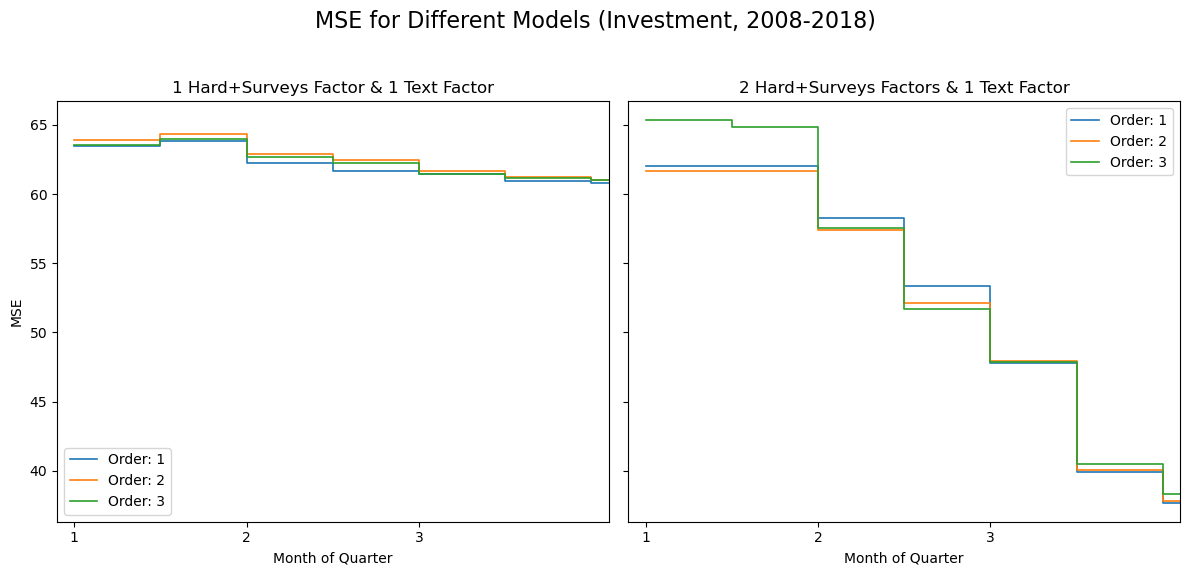

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


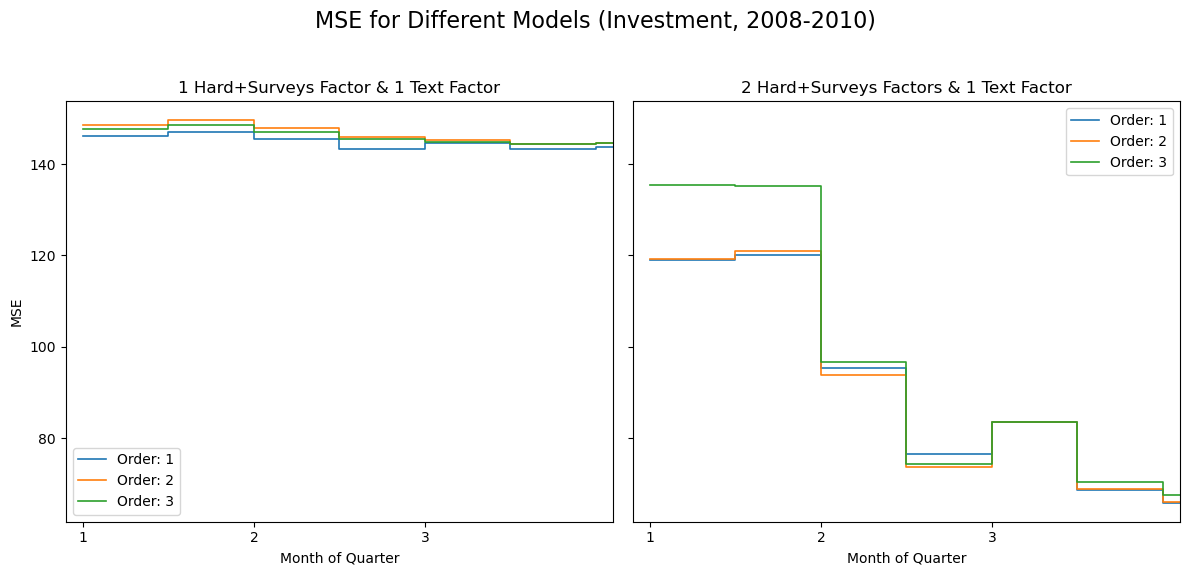

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


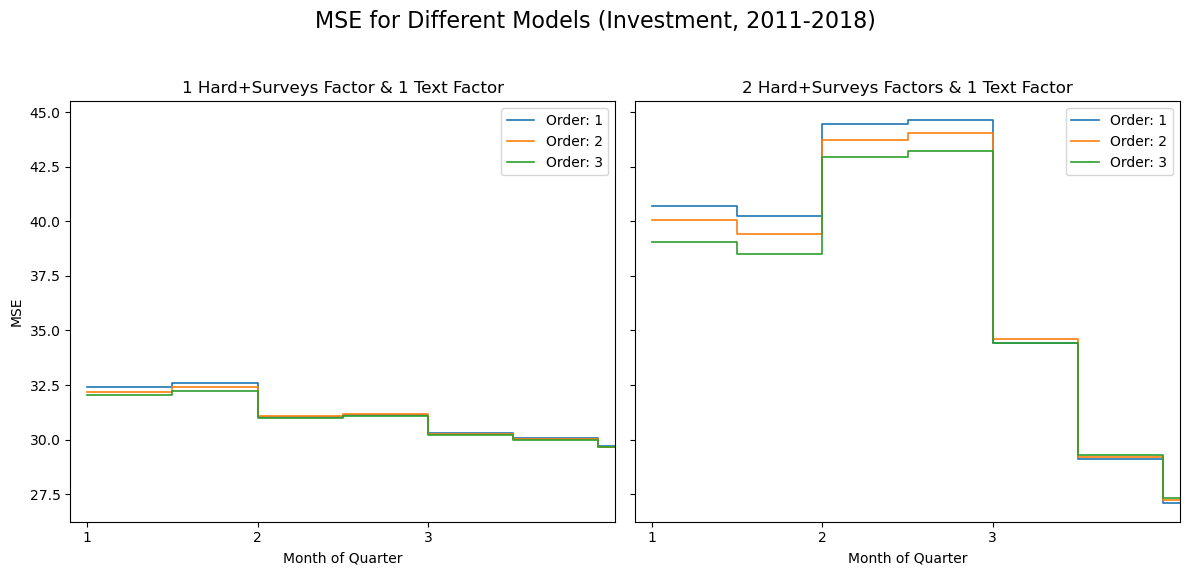

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


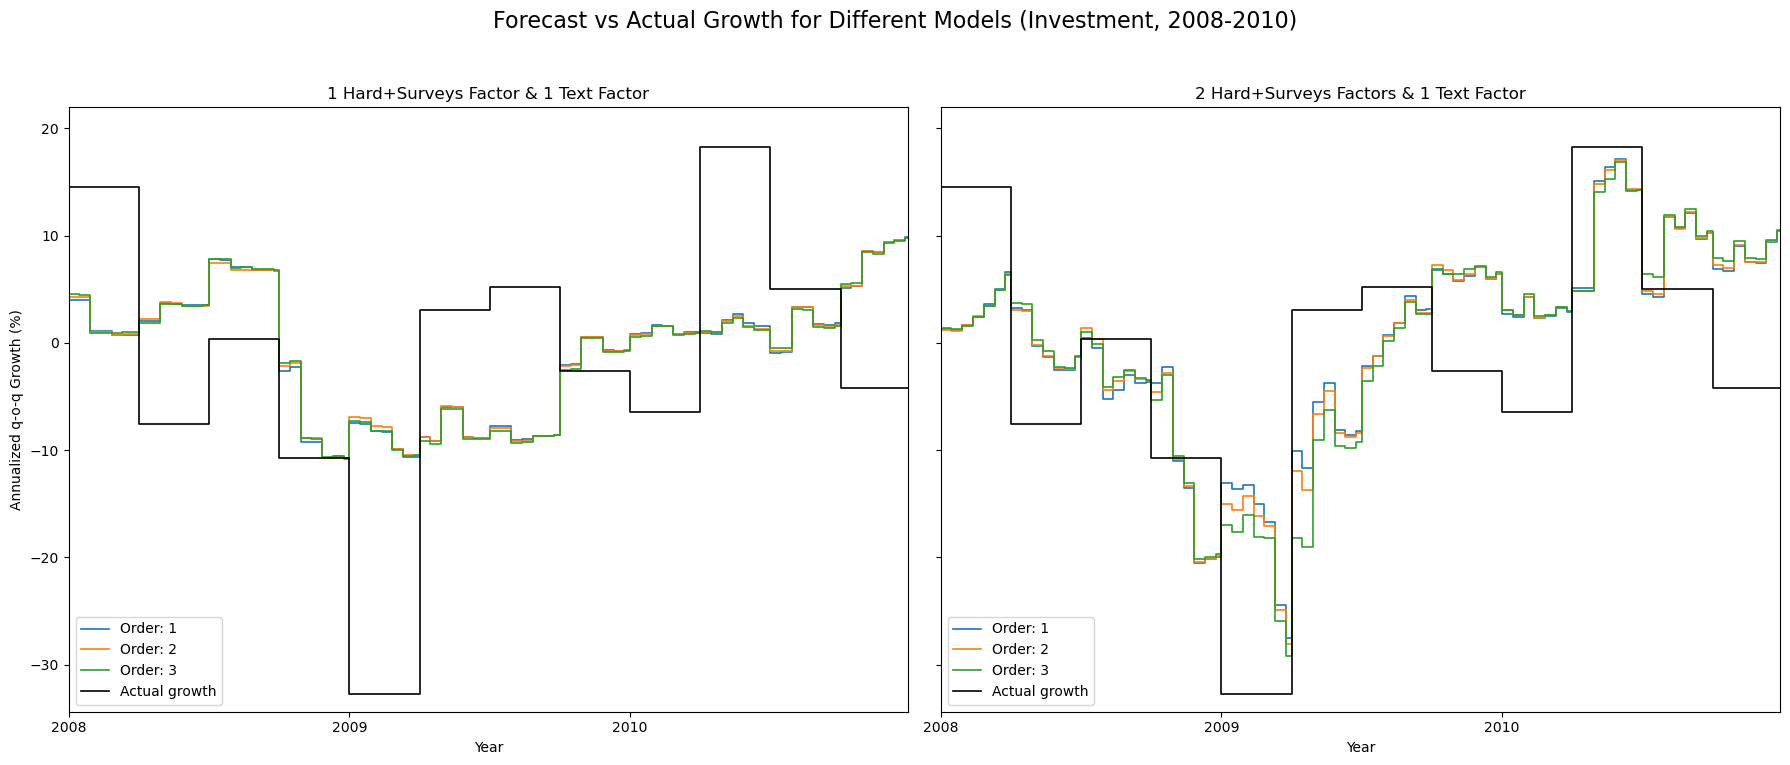

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


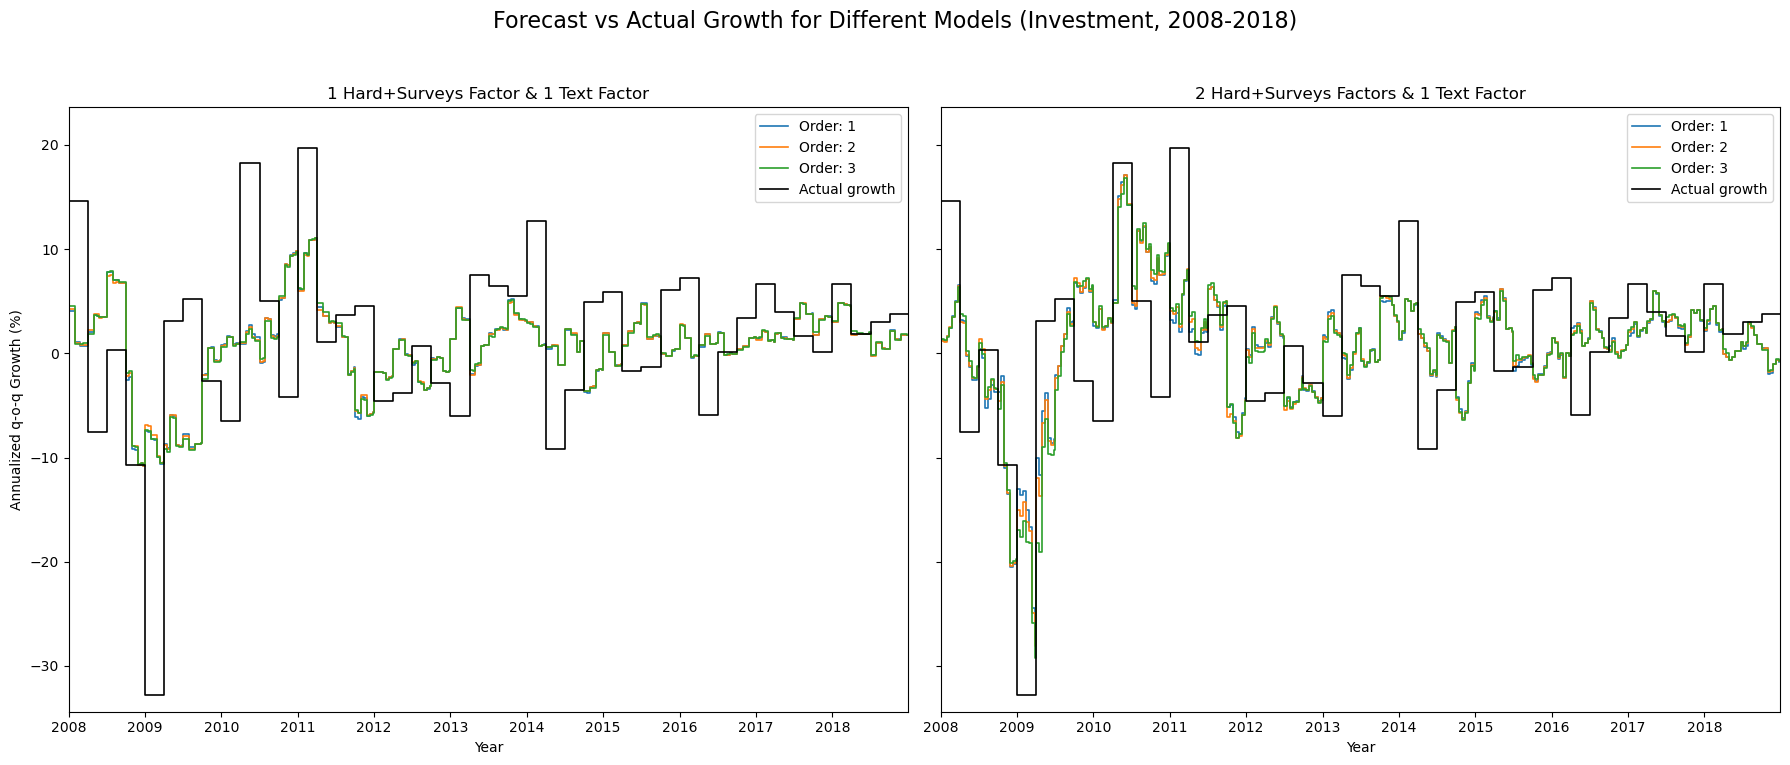

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


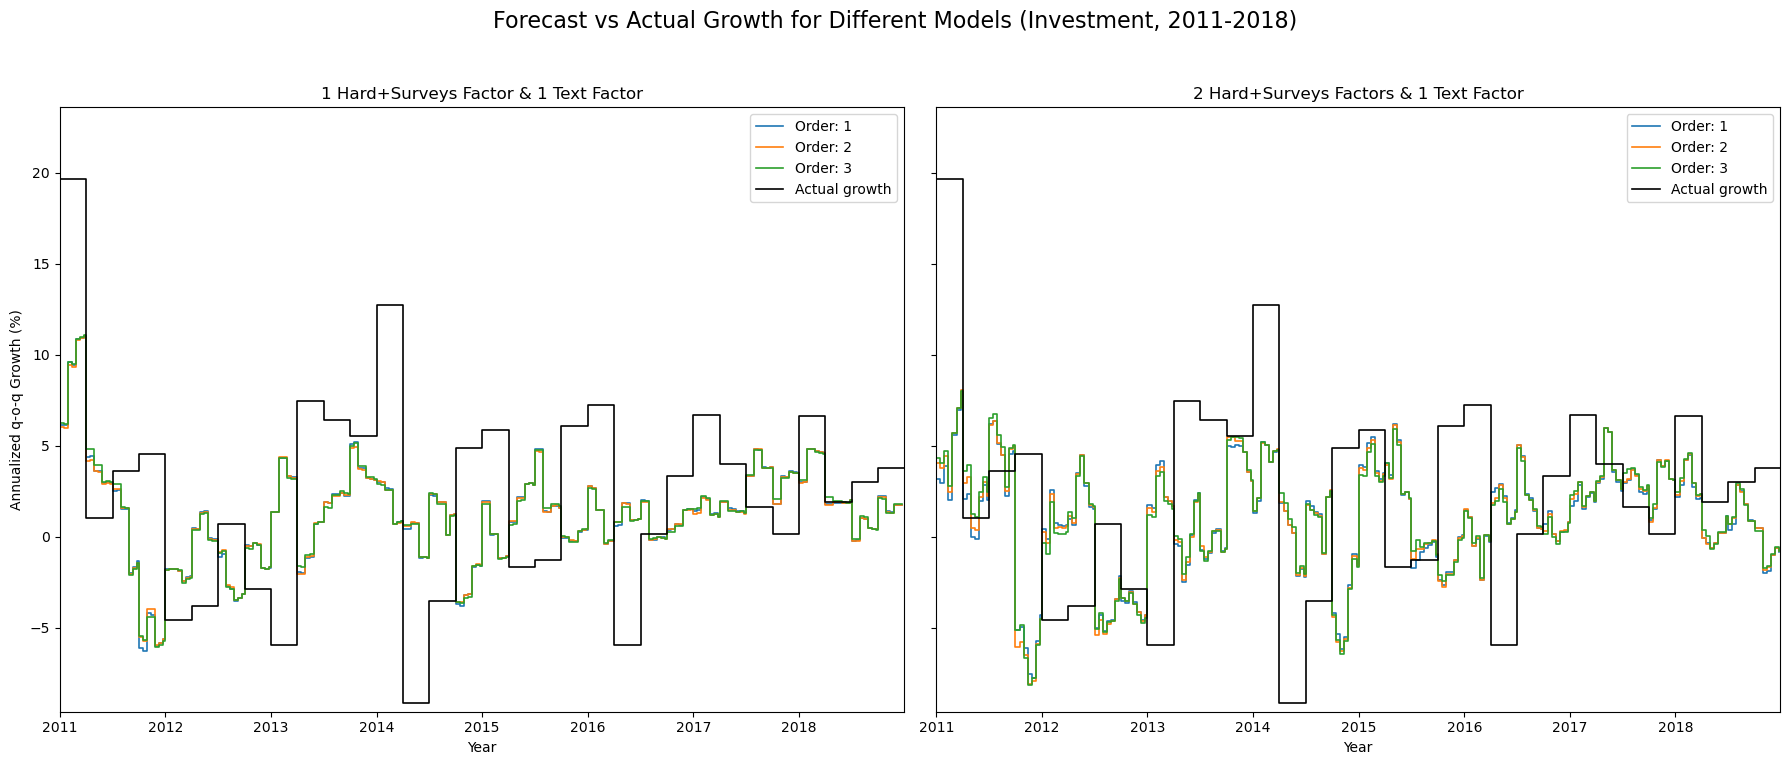

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()